In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex
from scipy.optimize import least_squares

- want to calculate the equilibrium underwhich there is a reserve bid that is less than the value that the high cost bidders would've bid. 
- i solve the equil bids in the unconstrained case using a numerical system of equations solver.
- i dont think that works in the same way with a bounded case.

In [3]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

- this is what i do for the non-bounded case. below is an example. let's start with two player

In [4]:
# EXAMPLE
R_     = 5
alpha_ = 3
costs   = [1, R_]
guesses   = [3, 5]
bids= getEquilBids(costs, a=alpha_, guess=guesses)
bids

array([ 9.03191683, 10.71104368])

In [6]:
xTilde  = getAllos(bids, a=alpha_)
xTilde, costs, np.dot(costs, xTilde)

(array([0.62516557, 0.37483443]), [1, 5], 2.499337708338014)

- for the bounded case if we set the reserve bid at say, 10. 
- i tried a "bounding box" thing, but that didn't work. what if i just use the function itself and implement the cap in as a min in the lambdify...

In [20]:
n       = 2
reserve = 10
alpha_  = 3
bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
cs = [1, R_]

denom = sum([sp.Min(bi, reserve)**(-alpha_) for bi in bs])
xs    = [sp.Min(bi, reserve)**(-alpha_)/denom for bi in bs]
xs[0]

1/((Min(10, b1)**(-3) + Min(10, b0)**(-3))*Min(10, b0)**3)

In [27]:
us    = [(sp.Min(bs[i], reserve) - cs[i])*xs[i] for i in range(n)]
us[1]

(Min(10, b1) - 5)/((Min(10, b1)**(-3) + Min(10, b0)**(-3))*Min(10, b1)**3)

In [24]:
diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
diffs[0]

-3*(Min(10, b0) - 1)*Heaviside(10 - b0)/((Min(10, b1)**(-3) + Min(10, b0)**(-3))*Min(10, b0)**4) + 3*(Min(10, b0) - 1)*Heaviside(10 - b0)/((Min(10, b1)**(-3) + Min(10, b0)**(-3))**2*Min(10, b0)**7) + Heaviside(10 - b0)/((Min(10, b1)**(-3) + Min(10, b0)**(-3))*Min(10, b0)**3)

In [25]:
funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]

In [35]:
def eqs(bs):
    return [f(*bs) for f in funcs]
    
fsolve(eqs, [1,1]),fsolve(eqs, [5,5]),fsolve(eqs, [8,8]),fsolve(eqs, [5,5])

(array([ 8.46982049, 10.01608372]),
 array([ 8.46982049, 10.02293035]),
 array([ 8.46982049, 10.29314493]),
 array([ 8.46982049, 10.02293035]))

- these all have the same value of b_0, lets check if it solves the eq.

In [37]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

u0 = ( (b0 - 1)*b0**(-alpha) ) / ( b0**(-alpha) + R**(-alpha) )
foc = sp.Eq(sp.simplify(sp.diff(u0, b0)),0)
foc

Eq(R**alpha*(R**alpha*alpha*(b0 - 1) - alpha*(R**alpha + b0**alpha)*(b0 - 1) + b0*(R**alpha + b0**alpha))/(b0*(R**alpha + b0**alpha)**2), 0)

In [72]:
u0

(b0 - 1)/(b0**alpha*(b0**(-alpha) + R**(-alpha)))

In [42]:
sp.nsolve(foc.evalf(subs={R:reserve, alpha:3}), reserve)

8.46982048740422

- yup that is what it reduces too. 
- let's check on the best response too...

In [66]:
c1, c2 = 1, 5
curr1, curr2 = 4, 4
a = 3

b1 = sp.Symbol('b1', positive=True)
b2 = sp.Symbol('b2', positive=True)

p1Bids, p2Bids = [curr1], [curr2]
turn = 0
for turn in tqdm(range(30)):
    if turn % 2 == 0:
        x1 = b1**(-a) / (b1**(-a) + b2**(-a))
        u1 = (b1-c1)*x1
        partial = sp.diff(u1, b1)
        best = sp.Eq(partial, 0).evalf(subs={b2:curr2})
        sol = sp.solve(best)[0]
        curr1 = sol
        p1Bids.append(curr1)
    else:
        x2 = b2**(-a) / (b1**(-a) + b2**(-a))
        u2 = (b2-c2)*x2
        partial = sp.diff(u2, b2)
        best = sp.Eq(partial, 0).evalf(subs={b1:curr1})
        sol = sp.solve(best)[0]
        curr2 = sol
        p2Bids.append(curr2)

100%|██████████| 30/30 [00:03<00:00,  9.73it/s]


In [67]:
# matches unbounded
p1Bids[-1],p2Bids[-1]

(9.03143923021108, 10.7107252268931)

In [87]:
c1, c2 = 1, 6
curr1, curr2 = 4, 4
a = 3

b1 = sp.Symbol('b1', positive=True)
b2 = sp.Symbol('b2', positive=True)

p1Bids, p2Bids = [curr1], [curr2]
turn = 0
for turn in tqdm(range(30)):
    if turn % 2 == 0:
        x1 = sp.Min(b1,10)**(-a) / (sp.Min(b1,10)**(-a) + sp.Min(b2,10)**(-a))
        u1 = (sp.Min(b1,10)-c1)*x1
        partial = sp.diff(u1, b1)
        best = sp.Eq(partial, 0).evalf(subs={b2:curr2})
        sol = sp.nsolve(best, b1, curr1)
        curr1 = sol
        p1Bids.append(curr1)
    else:
        x2 = sp.Min(b2,10)**(-a) / (sp.Min(b1,10)**(-a) + sp.Min(b2,10)**(-a))
        u2 = (sp.Min(b2,10)-c2)*x2
        partial = sp.diff(u2, b2)
        best = sp.Eq(partial, 0).evalf(subs={b1:curr1})
        sol = sp.nsolve(best, b2, curr2)
        curr2 = sol
        p2Bids.append(curr2)

100%|██████████| 30/30 [00:00<00:00, 49.54it/s]


In [89]:
# matches unbounded
p1Bids[-1],p2Bids[-1]

(8.46982048740422, 10.5958035515675)

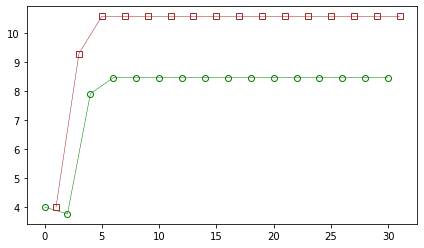

In [90]:
f, ax = plt.subplots(figsize=(7,4))


ax.plot(np.arange(0,31,2), p1Bids, marker='o', fillstyle='none',
              linewidth=0.5, color='green', label='player 1')
ax.plot(np.arange(1,32,2), p2Bids, marker='s', fillstyle='none', 
              linewidth=0.5, color='brown', label='player 2')

plt.show()

# revised figure

In [139]:
def getBoundedEquilBids(cs, a, reserve, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([sp.Min(bi,reserve)**(-a) for bi in bs])
    xs    = [sp.Min(bi,reserve)**(-a)/denom for bi in bs]
    us    = [(sp.Min(bs[i],reserve) - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getBoundedAllos(bids, a, reserve):
    bids = np.array([np.min([b, reserve]) for b in bids])
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [154]:
c1s     = np.arange(1, 18.01, 0.1)
guesses = c1s
reserve = 20
alpha_  = 3

In [155]:
getBoundedEquilBids([1, 18], alpha_, reserve, guess=[4,4])

array([16.3900899 , 20.41598278])

In [156]:
bb          = []
xTildes_bb  = []
welfares_bb = []
for i, c1 in enumerate(c1s):
    costs  = [1, c1]
    bids   = getBoundedEquilBids(costs, a=alpha_, reserve=reserve, guess=[5, 5])
    bids   = np.array([np.min([b, reserve]) for b in bids])
    xTilde = getBoundedAllos(bids, a=alpha_, reserve=reserve)
    bb.append(bids)
    xTildes_bb.append(xTilde)
    welfares_bb.append(np.dot(costs, xTilde))
bb          = np.asarray(bb)
xTildes_bb  = np.asarray(xTildes_bb)
welfares_bb = np.asarray(welfares_bb)
bb.shape, xTildes_bb.shape, welfares_bb.shape

((171, 2), (171, 2), (171,))

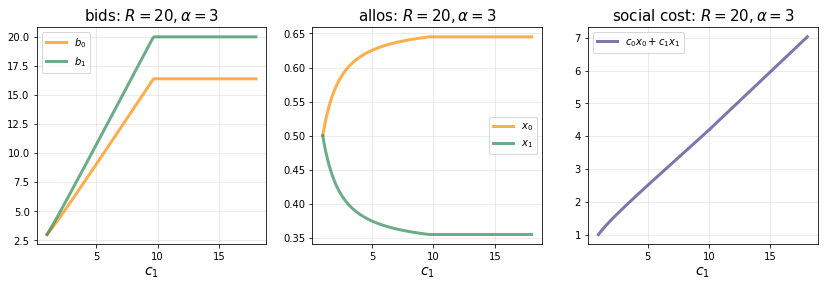

In [157]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['darkorange', 'seagreen', 'darkslateblue']
  
axarr[0].plot(c1s, bb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$b_0$')
axarr[0].plot(c1s, bb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$b_1$')
axarr[0].set_title(r'bids: $R={},\alpha={}$'.format(reserve,alpha_), size=15)

axarr[1].plot(c1s, xTildes_bb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$x_0$')
axarr[1].plot(c1s, xTildes_bb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$x_1$')
axarr[1].set_title(r'allos: $R={},\alpha={}$'.format(reserve,alpha_), size=15)

axarr[2].plot(c1s, welfares_bb, color='darkslateblue', linewidth=3, alpha=0.7, label=r'$c_0x_0+c_1x_1$')
axarr[2].set_title(r'social cost: $R={},\alpha={}$'.format(reserve,alpha_), size=15)


for i, ax in enumerate(axarr):
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_1$', size=14)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [163]:
c1, c2 = 1, 10
curr1, curr2 = 5, 5
a = 3
reserve = 20

b1 = sp.Symbol('b1', positive=True)
b2 = sp.Symbol('b2', positive=True)

p1Bids, p2Bids = [curr1], [curr2]
turn = 0
for turn in tqdm(range(30)):
    if turn % 2 == 0:
        x1 = sp.Min(b1,reserve)**(-a) / (sp.Min(b1,reserve)**(-a) + sp.Min(b2,reserve)**(-a))
        u1 = (sp.Min(b1,reserve)-c1)*x1
        partial = sp.diff(u1, b1)
        best = sp.Eq(partial, 0).evalf(subs={b2:curr2})
        sol = sp.nsolve(best, b1, curr1)
        curr1 = sol
        p1Bids.append(curr1)
    else:
        x2 = sp.Min(b2,reserve)**(-a) / (sp.Min(b1,reserve)**(-a) + sp.Min(b2,reserve)**(-a))
        u2 = (sp.Min(b2,reserve)-c2)*x2
        partial = sp.diff(u2, b2)
        best = sp.Eq(partial, 0).evalf(subs={b1:curr1})
        sol = sp.nsolve(best, b2, curr2)
        curr2 = sol
        p2Bids.append(curr2)

100%|██████████| 30/30 [00:01<00:00, 28.92it/s]


In [164]:
# matches unbounded
p1Bids[-1],p2Bids[-1]

(16.3900899012162, 20.0071262586321)

In [166]:
bb[:,0][-1], bb[:,1][-1]

(16.39008990121622, 20.0)

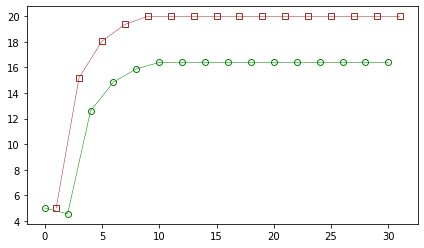

In [165]:
f, ax = plt.subplots(figsize=(7,4))


ax.plot(np.arange(0,31,2), p1Bids, marker='o', fillstyle='none',
              linewidth=0.5, color='green', label='player 1')
ax.plot(np.arange(1,32,2), p2Bids, marker='s', fillstyle='none', 
              linewidth=0.5, color='brown', label='player 2')

plt.show()

# Three player, bounded strategic

In [177]:
def getBoundedEquilBids(cs, a, reserve, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([sp.Min(bi,reserve)**(-a) for bi in bs])
    xs    = [sp.Min(bi,reserve)**(-a)/denom for bi in bs]
    us    = [(sp.Min(bs[i],reserve) - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getBoundedAllos(bids, a, reserve):
    bids = np.array([np.min([b, reserve]) for b in bids])
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [178]:
reserve = 20
alpha_  = 3

getBoundedEquilBids([1, 8, 15], alpha_, reserve, guess=[4,7,20])

array([10.92091376, 14.61991401, 20.00000177])

In [180]:
getBoundedAllos(getBoundedEquilBids([1, 8, 15], alpha_, reserve, guess=[4,7,20]), alpha_, reserve)

array([0.63306109, 0.26386884, 0.10307007])

In [237]:
# checking
alpha = 3.
costs = [1,15,15,20]
bids = getEquilBids(costs, alpha_, guess=[2,5,5,5])
allos = getAllos(bids, alpha_)
poa = np.dot(costs, allos)
bids, allos, poa

(array([14.90117667, 24.55843789, 24.55843789, 31.17645936]),
 array([0.64268788, 0.14356864, 0.14356864, 0.07017484]),
 6.353243859968037)

In [239]:
# checking
alpha = 3.
costs = [1,20,20,20]
bids = getEquilBids(costs, alpha_, guess=[2,5,5,5])
allos = getAllos(bids, alpha_)
poa = np.dot(costs, allos)
bids, allos, poa

(array([18.20236033, 32.14115687, 32.14115687, 32.14115687]),
 array([0.64728948, 0.11757017, 0.11757017, 0.11757017]),
 7.701499864757562)

In [197]:
c1s     = np.arange(8, 18.01, 0.1)
guesses = c1s
reserve = 20
alpha_  = 3

In [198]:
bb          = []
xTildes_bb  = []
welfares_bb = []
for i, c1 in enumerate(c1s):
    costs  = [1, 8, c1]
    bids   = getBoundedEquilBids(costs, a=alpha_, reserve=reserve, guess=[5, 5, 5])
    bids   = np.array([np.min([b, reserve]) for b in bids])
    xTilde = getBoundedAllos(bids, a=alpha_, reserve=reserve)
    bb.append(bids)
    xTildes_bb.append(xTilde)
    welfares_bb.append(np.dot(costs, xTilde))
bb          = np.asarray(bb)
xTildes_bb  = np.asarray(xTildes_bb)
welfares_bb = np.asarray(welfares_bb)
bb.shape, xTildes_bb.shape, welfares_bb.shape

((101, 3), (101, 3), (101,))

In [202]:
ubb          = []
xTildes_ubb  = []
welfares_ubb = []
for i, c1 in enumerate(c1s):
    costs  = [1, 8, c1]
    bids   = getEquilBids(costs, a=alpha_, guess=[5, 5, 5])
    xTilde = getAllos(bids, a=alpha_)
    ubb.append(bids)
    xTildes_ubb.append(xTilde)
    welfares_ubb.append(np.dot(costs, xTilde))
ubb          = np.asarray(ubb)
xTildes_ubb  = np.asarray(xTildes_ubb)
welfares_ubb = np.asarray(welfares_ubb)
ubb.shape, xTildes_ubb.shape, welfares_ubb.shape

((101, 3), (101, 3), (101,))

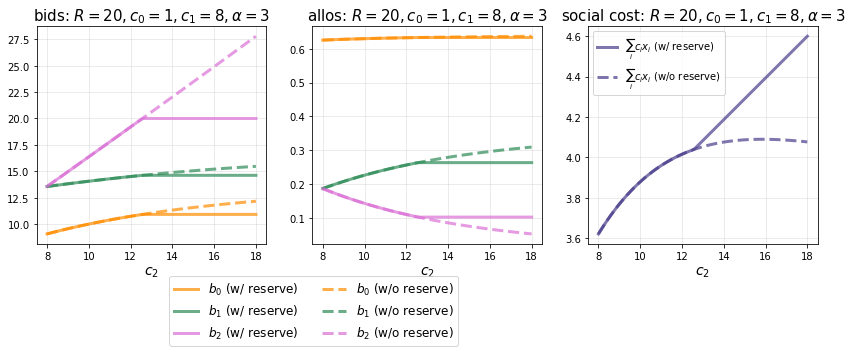

In [216]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['darkorange', 'seagreen', 'darkslateblue']
  
axarr[0].plot(c1s, bb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$b_0$ (w/ reserve)')
axarr[0].plot(c1s, bb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$b_1$ (w/ reserve)')
axarr[0].plot(c1s, bb[:,2], color='orchid', linewidth=3, alpha=0.7, label=r'$b_2$ (w/ reserve)')
axarr[0].set_title(r'bids: $R={}, c_0=1, c_1=8, \alpha={}$'.format(reserve,alpha_), size=15)
axarr[0].plot(c1s, ubb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$b_0$ (w/o reserve)',
              linestyle='--')
axarr[0].plot(c1s, ubb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$b_1$ (w/o reserve)',
              linestyle='--')
axarr[0].plot(c1s, ubb[:,2], color='orchid', linewidth=3, alpha=0.7, label=r'$b_2$ (w/o reserve)',
              linestyle='--')
axarr[0].set_title(r'bids: $R={}, c_0=1, c_1=8, \alpha={}$'.format(reserve,alpha_), size=15)


axarr[1].plot(c1s, xTildes_bb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$x_0 (w/ reserve)$')
axarr[1].plot(c1s, xTildes_bb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$x_1 (w/ reserve)$')
axarr[1].plot(c1s, xTildes_bb[:,2], color='orchid', linewidth=3, alpha=0.7, label=r'$x_2 (w/ reserve)$')
axarr[1].plot(c1s, xTildes_ubb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$x_0 (w/o reserve)$',
              linestyle='--')
axarr[1].plot(c1s, xTildes_ubb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$x_1$ (w/o reserve)',
              linestyle='--')
axarr[1].plot(c1s, xTildes_ubb[:,2], color='orchid', linewidth=3, alpha=0.7, label=r'$x_2$ (w/o reserve)',
              linestyle='--')
axarr[1].set_title(r'allos: $R={}, c_0=1, c_1=8, \alpha={}$'.format(reserve,alpha_), size=15)


axarr[2].plot(c1s, welfares_bb, color='darkslateblue', linewidth=3, alpha=0.7, label=r'$\sum_i c_i x_i$ (w/ reserve)')
axarr[2].plot(c1s, welfares_ubb, color='darkslateblue', linewidth=3, alpha=0.7, label=r'$\sum_i c_i x_i$ (w/o reserve)',
              linestyle='--')
axarr[2].set_title(r'social cost: $R={},c_0=1, c_1=8,\alpha={}$'.format(reserve,alpha_), size=15)


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=14)
    
handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.4, -0.25), ncol=2, fontsize=12)
axarr[2].legend()


plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# POA maximization problem

In [327]:
import copy

In [337]:
def objective_function(costs, alpha):
    guess = [2*c for c in costs]
    bids = getEquilBids(costs, alpha, guess)
    allos = getAllos(bids, alpha)
    min_cost = np.min(costs)
    poa = np.dot(costs, allos) / min_cost
    return -poa  # Negative for maximization

In [338]:
MAX_COST = 20
alpha    = 3
initial_costs = np.array([1, 2, 2, 4, 4])

In [339]:
bounds = [(1, MAX_COST) for _ in initial_costs]
result = minimize(
    objective_function,
    initial_costs,
    args=(alpha),
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True}
)

<lambdifygenerated-22943>:2: RuntimeWarning: overflow encountered in double_scalars
  return 1/(b4**3*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))) - 3*(b4 - 4.01050704607408)/(b4**4*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))) + 3*(b4 - 4.01050704607408)/(b4**7*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))**2)
<lambdifygenerated-22940>:2: RuntimeWarning: overflow encountered in double_scalars
  return 1/(b1**3*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))) - 3*(b1 - 2.01229561898657)/(b1**4*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))) + 3*(b1 - 2.01229561898657)/(b1**7*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))**2)
<lambdifygenerated-22941>:2: RuntimeWarning: overflow encountered in double_scalars
  return 1/(b2**3*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) + b0**(-3.0))) - 3*(b2 - 2.01229543018073)/(b2**4*(b4**(-3.0) + b3**(-3.0) + b2**(-3.0) + b1**(-3.0) 

In [340]:
result

      fun: -2.255049417232918
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.40548054e+00, -8.88178425e-08, -8.88178425e-08,  5.56475266e+07,
       -1.75720151e-01])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 174
      nit: 1
     njev: 29
   status: 2
  success: False
        x: array([1.        , 2.01229561, 2.01229542, 3.99947254, 3.99936856])

In [313]:
# checking
alpha = 3.
costs = [1,20,20,20,20,20]
bids = getEquilBids(costs, alpha_, guess=[2,5,5,5,5,5])
allos = getAllos(bids, alpha_)
poa = np.dot(costs, allos)
bids, allos, poa

(array([14.99941884, 31.20000372, 31.20000372, 31.20000372, 31.20000372,
        31.20000372]),
 array([0.64285615, 0.07142877, 0.07142877, 0.07142877, 0.07142877,
        0.07142877]),
 7.78573306535354)